In [ ]:
pip install pyforest

## Fight against Coronavirus

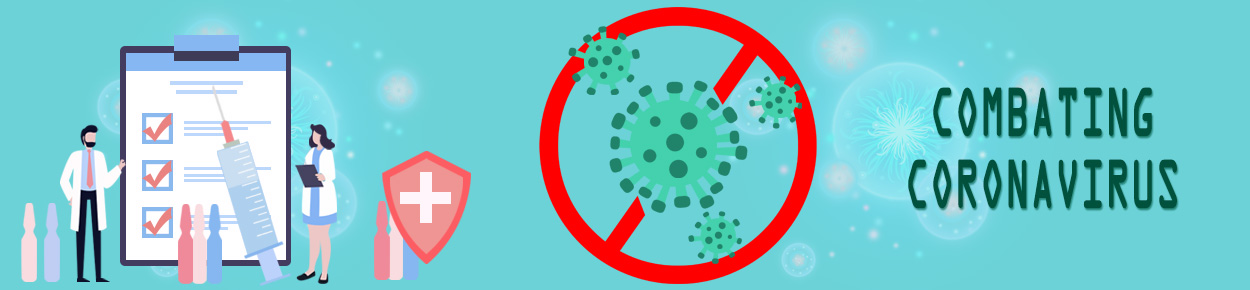

https://www.india.gov.in/spotlight/combating-coronavirus

In [ ]:
from pyforest import *
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
import plotly.graph_objects as go

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format 

In [ ]:
country_vacc = pd.read_csv('../input/covid-world-vaccination-progress/country_vaccinations.csv')
country_vacc_by_mfg = pd.read_csv('../input/covid-world-vaccination-progress/country_vaccinations_by_manufacturer.csv')

In [ ]:
country_vacc.head()

In [ ]:
print('No of rows in country_vacc:',country_vacc.shape[0])
print('No of columns in country_vacc:',country_vacc.shape[1])

In [ ]:
dups = country_vacc.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
country_vacc[dups]

In [ ]:
country_vacc.info()

In [ ]:
country_vacc['date'] = country_vacc['date'].apply(pd.to_datetime)

In [ ]:
country_vacc['Month_Year'] = country_vacc['date'].dt.to_period('M')

In [ ]:
country_vacc.info()

In [ ]:
country_vacc.isnull().values.any()

In [ ]:
country_vacc.isnull().sum()/country_vacc.shape[0]*100

In [ ]:
missing = country_vacc.isnull().sum()/country_vacc.shape[0]*100 > 35
missing = missing.to_frame().reset_index().rename(columns={'index':'Columns',0:'More than 35% missing'})
missing = missing[missing['More than 35% missing']==True]
missing

In [ ]:
missing = country_vacc.isnull().sum()/country_vacc.shape[0]*100 > 50
missing = missing.to_frame().reset_index().rename(columns={'index':'Columns',0:'More than 50% missing'})
missing = missing[missing['More than 50% missing']==True]
missing

**Insight**

`'total_vaccinations','people_vaccinated','people_fully_vaccinated','daily_vaccinations_raw','total_vaccinations_per_hundred',
'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred'` have more than 35% of the data missing.


The columns `people_fully_vaccinated` and `people_fully_vaccinated_per_hundred` have more than 50% of the data missing.
Since there is no sufficient amount of data to impute the missing values we will drop the bad data and only work with what we have.

In [ ]:
country_vacc.dropna(inplace=True)

In [ ]:
print('No of rows in country_vacc after dropping the NA:',country_vacc.shape[0])
print('No of columns in country_vacc after dropping the NA:',country_vacc.shape[1])

In [ ]:
country_vacc.isnull().sum()/country_vacc.shape[0]*100

In [ ]:
cat = []
num = []
for i in country_vacc.columns:
    if country_vacc[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)
print('Categorical Columns = \n\n{}\n\nNumerical Columns = \n\n{}'.format(cat,num))        


In [ ]:
num.remove('date')
num.remove('Month_Year')
num

## Univariate Analysis

### Numerical

skewness = 0 : normally distributed.


skewness > 0 : more weight in the left tail of the distribution.


skewness < 0 : more weight in the right tail of the distribution. 

In [ ]:
for i in num:
    print('\n',i,':\nSkewnes of the data = {}'.format(skew(country_vacc[i])))

In [ ]:
red_patch = mlines.Line2D([],[],color='red', marker='_',label='kde')
black_patch = mlines.Line2D([],[],color='black', marker='_',label='norm')

for i in num:
    plt.figure(figsize=[10,5])
    sns.distplot(country_vacc[i],hist=False,kde_kws={"shade":True,"color": "r","linewidth":1},fit=norm)
    Q1 = plt.axvline(x=(country_vacc[i].quantile(0.25)),color='g',linestyle='--',label='Q1')
    Q2 = plt.axvline(x=(country_vacc[i].quantile(0.5)),color='orange',linestyle='--',label='Q2')
    Q3 = plt.axvline(x=(country_vacc[i].quantile(0.75)),color='r',linestyle='--',label='Q3')

    mean = plt.axvline(x=(country_vacc[i].mean()),color='b',label='mean')
    sd = plt.axvline(x=(country_vacc[i].std()),color='g',label='SD')
    
    plt.legend(handles=[red_patch,black_patch,mean,sd,Q1,Q2,Q3],fontsize=14)

    plt.title(i)
    plt.tight_layout()
    plt.show()

**Insights**

The data is highly skewed to the left. In a normal distribution, the mean and the median are the same however when the data is skewed the mean and median are different.

A left-skewed, negative distribution will have the mean to the left of the median

## Univariate Analysis


### Categorical

In [ ]:
plt.figure(figsize=[10,20])
sns.countplot(y=country_vacc.vaccines,palette='gist_earth',
             order=country_vacc['vaccines'].value_counts().index)
plt.xticks(rotation=90);

**Insights**

`Moderna, Oxford/AstraZeneca, Pfizer/BioNTech` are the top 3 vaccines that are utilized by 41.51% of the data.

In [ ]:
plt.figure(figsize=[10,20])
sns.countplot(y=country_vacc.country,palette='gist_earth',
             order=country_vacc['country'].value_counts().index)
plt.xticks(rotation=90);

**Insights**

`Germany (2.6002%), Israel (2.4332%), Canada (2.3616%), Slovenia (2.3378%) and England (2.2424%)` are the top 5 countries with highest count.

## Bivariate Analysis
### Numeric and Numeric

In [ ]:
for i in num:
    plt.figure(figsize =[15,5])
    sns.violinplot(country_vacc[i],palette='mako')
    plt.title(i,fontsize =14)
    plt.show()

**Insights**

Large number of population not vaccinated since the data is more concentrated towards 0. However, there seems to be steady increase in vaccination by per hundred.

### Category and Category

In [ ]:
vaccines = pd.crosstab(country_vacc.vaccines,country_vacc.country,margins=True,margins_name='Total')
vaccines.sort_values(by='Total',ascending=False,inplace=True,axis=0)
vaccines.sort_values(by='Total',ascending=False,inplace=True,axis=1)
vaccines.drop('Total',axis=0,inplace=True)
vaccines.drop('Total',axis=1,inplace=True)
vaccines = vaccines.iloc[:5,:10]

vaccines

In [ ]:
ax = vaccines.plot.area(figsize=[15,10])
plt.xticks(rotation=90)
plt.title('Top 5 vaccines in top 10 countries',fontsize=14)
plt.show()

**Insights**

`Germany` and `Canada` authorized vaccines are `Moderna, Oxford/AstraZeneca, Pfizer/BioNTech` 


`Moderna, Pfizer/BioNTech` is also authorized by `Israel`.


`Oxford/AstraZeneca, Pfizer/BioNTech` are most popular choice of vaccine.

In [ ]:
fig = px.bar(country_vacc,x='date',color='country')
fig.update_layout(paper_bgcolor="snow")
fig.show()

**Insights**

`Germany` and `Israel` are one of the few countries that initiated the vaccination drive from early January of 2021. By the end of February most of the countries were able to kick off their vaccination drive.

### Numeric and Category

In [ ]:
country = country_vacc.groupby(by='country').sum()
country.head()

In [ ]:
top10_totvacc = country.sort_values(by='total_vaccinations',ascending=False).iloc[:10,:3]
top10_totvacc

In [ ]:
plt.figure(figsize =[15,5])
sns.kdeplot(data=top10_totvacc)
plt.title('KDE Density for total vaccinations and people vaccinated of top 10 countries',fontsize=14);
top10_totvacc.plot.line(figsize=[15,5])
plt.xticks(rotation =90,ticks=np.arange(0,10),labels=top10_totvacc.index)
plt.title('Top 10 countries with highest total vaccination',fontsize=14);

**Insights**

`United States`, `India` and `United Kingdom` are the leading countries to have most of thier population vaccinated. 

`United States`	produced **7,780,421,334** total vaccination from which **5,193,875,282** are vaccinated with the first dose and **2,641,238,684** are fully vaccinated.


`India` produced **2,732,667,157** total vaccination out of which **2,345,637,502** are vaccinated with the first dose and **387,029,655** are fully vaccinated.


`United Kingdom` produced **1,968,833,520** total vaccination out of which **1,786,516,694** are vaccinated with the first dose and **182,316,826** are fully vaccinated.

In [ ]:
top10_perhund = country.sort_values(by='total_vaccinations_per_hundred',ascending=False).iloc[:10,5:-1]
top10_perhund

In [ ]:
plt.figure(figsize =[15,5])
sns.kdeplot(data=top10_perhund)
plt.title('KDE Density for total vaccinations and people vaccinated per hundred of top 10 countries',fontsize=14);
top10_perhund.plot.line(figsize=[15,5])
plt.xticks(rotation =90,ticks=np.arange(0,10),labels=top10_perhund.index)
plt.title('Top 10 countries with highest total vaccination per hundred',fontsize=14);

**Insights**

`Israel` produced **8,202** total vaccination per hundred out of which **4,765.4600** people vaccinated per hundred with the first dose and **3,436.5300** people fully vaccinated per hundred.


`Gibraltar` produced **7,233.0200** total vaccination per hundred out of which **4,361.8800** people vaccinated per hundred with the first dose and **2,870.3300** people fully vaccinated per hundred.


`Wales`	produced **3,166.1500** total vaccination per hundred out of which **2,636.8300** people vaccinated per hundred with the first dose and **529.3000** people fully vaccinated per hundred.


In [ ]:
date_vacc = country_vacc.groupby(by='Month_Year').sum().sort_values(by='Month_Year',ascending=True)
date_vacc

In [ ]:
date_vacc.iloc[:,:3].plot.bar(figsize=[15,5])
plt.title('Vaccination Progress from Dec 2020 to April 2021',fontsize=14);
date_vacc.iloc[:,5:-1].plot.area(figsize=[15,5])
plt.title('Vaccination Progress from Dec 2020 to April 2021\n(per hundred)',fontsize=14);

**Insights**

We can see there is steady increase from `January 2021` in *total_vaccination*, *people_vaccinated* and *people_fully_vaccinated* till `March 2021` and see a sudden decline in `April 2021`. Though the total_vaccination is increasing steadily. The reason for decline could be the waiting period of 6-8 weeks between the 1st dose and the second dose. 

In [ ]:
country_vacc_by_mfg.head()

In [ ]:
country_vacc_by_mfg.info()

In [ ]:
print('No of rows in country_vacc_by_mfg:',country_vacc_by_mfg.shape[0])
print('No of columns in country_vacc_by_mfg:',country_vacc_by_mfg.shape[1])

In [ ]:
country_vacc_by_mfg.describe().T

In [ ]:
at_50= country_vacc_by_mfg[country_vacc_by_mfg['total_vaccinations'] < 
                                country_vacc_by_mfg['total_vaccinations'].quantile(0.50)]
at_50.head()
print(at_50.shape)

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(15,15))
a = sns.distplot(at_50.total_vaccinations,ax=axes[0],hist=False,kde_kws={"shade":True,'color':'r'},fit=norm)
a.set_title('Descriptive Statistics at 50% of data',fontsize=14)
sns.boxplot(at_50.total_vaccinations,ax=axes[1])
plt.show();

In [ ]:
dups = country_vacc_by_mfg.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
country_vacc_by_mfg[dups]

In [ ]:
country_vacc_by_mfg.isnull().values.any()

In [ ]:
mfg = country_vacc_by_mfg.groupby(by='location').sum().sort_values(by='total_vaccinations',ascending=False)
mfg.T

In [ ]:
mfg.plot.bar(figsize=[15,5])
plt.title('Total Vaccination produced by countries',fontsize=14);

**Insights**

`United States` is by far the largest vaccinated country  with **7,849,710,124** total vaccinations. 


Even though `Germany` (732,007,653) and `Italy` (529,272,173) does not have vaccines at a large scale as US, they still have adequate number of total vaccinations.

In [ ]:
country_vacc_by_mfg['date'] = country_vacc_by_mfg['date'].apply(pd.to_datetime)

In [ ]:
country_vacc_by_mfg['Year_Month'] = country_vacc_by_mfg['date'].dt.to_period('M')

In [ ]:
country_vacc_by_mfg.tail()

In [ ]:
df = country_vacc_by_mfg.groupby(by=['location','Year_Month']).sum()
df.reset_index(inplace=True)
df.head()

In [ ]:
plt.figure(figsize =[15,5])
ax = sns.pointplot(x=df.Year_Month,y=df.total_vaccinations,hue=df.location,scale=1.8);
ax.legend(loc='lower right', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True);

**Insights**

Through time all the utilization of the vaccines are increasing steadily with `United States` as a outlier with highest consumption of vaccines from the month of `January 2021`. The country showed a huge surge in vaccination by `February` and is leading still. `Germany` have a good progress in vaccination from `February` and is steady since `March`. 

In [ ]:
country_vacc_by_mfg.head()

In [ ]:
vacc_tot = country_vacc_by_mfg.groupby(by='vaccine').sum()
vacc_tot

In [ ]:
vacc_tot.plot.pie(subplots=True,figsize=[10,10],autopct='%.2f',title='Vaccines', fontsize=15)
plt.legend(loc='lower left', bbox_to_anchor=(0.7, 1.05),
          ncol=3, fancybox=True, shadow=True);

**Insights**

`Pfizer/BioNTech` utilizes **54.20%** and `Moderna` utilizes **38.23%** of total vaccinations. These are the highest ranking manufacturers.

`Johnson&Johnson` utilizes **1.29%**, `Oxford/AstraZeneca` utilizes **2.21%** and `Sinovac` utilizes **4.07%** of total vaccinations

In [ ]:
count_vacc = pd.crosstab(country_vacc_by_mfg.location,country_vacc_by_mfg.vaccine)
count_vacc

In [ ]:
count_vacc.plot.bar(figsize=[15,5])
plt.legend(loc='lower right', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True);

**Insights**

`Pfizer/BioNTech` is approved by all the countries ['United States', 'Chile', 'Romania', 'Italy', 'Iceland', 'Germany', 'Lithuania', 'Latvia', 'Czechia'].

`Sinovac` is the authorized vaccine only in `Chile`

`Oxford/AstraZeneca` and `Moderna` are the 2nd ranking vaccine that is authorized by most of the countries.

`Johnson&Johnson` is only approved by `United States`

`Pfizer/BioNTech` and `Moderna` are the most popular vaccines, followed by `Oxford/AstraZeneca`

**Conclusions**




* 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations_raw', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred' have more than 35% of the data missing.



* The columns people_fully_vaccinated and people_fully_vaccinated_per_hundred have more than 50% of the data missing. Since there is no sufficient amount of data to impute the missing values we have dropped the bad data and only worked with what we have.



* The data is highly skewed to the left. In a normal distribution, the mean and the median are the same however when the data is skewed the mean and median are different.

    > A left-skewed, negative distribution will have the mean to the left of the median




* Moderna, Oxford/AstraZeneca, Pfizer/BioNTech are the top 3 vaccines that is utilized by 41.51% of the data.



* Large number of population not vaccinated since the data is more concentrated towards 0. However, there seems to be steady increase in vaccination by per hundred.

* Germany (2.6002%), Israel (2.4332%), Canada (2.3616%), Slovenia (2.3378%) and England (2.2424%) are the top 5 countries with highest count in vaccination.

* Germany and Israel are one of the few countries that initiated the vaccination drive from early January of 2021. By the end of February most of the countries were able to kick off their vaccination drive.


* Germany and Canada authorized vaccines are Moderna, Oxford/AstraZeneca, Pfizer/BioNTech

* Moderna, Pfizer/BioNTech is also authorized by Israel.

* Oxford/AstraZeneca, Pfizer/BioNTech are most popular choice of vaccine.




* United States, India and United Kingdom are the leading countries to have most of thier population vaccinated.

    > United States produced 7,780,421,334 total vaccination from which 5,193,875,282 are vaccinated with the first dose and 2,641,238,684 are fully vaccinated.

    > India produced 2,732,667,157 total vaccination out of which 2,345,637,502 are vaccinated with the first dose and 387,029,655 are fully vaccinated.

    > United Kingdom produced 1,968,833,520 total vaccination out of which 1,786,516,694 are vaccinated with the first dose and 182,316,826 are fully vaccinated.



* Israel has 8,202 total vaccination per hundred out of which 4,765.4600 people vaccinated per hundred with the first dose and 3,436.5300 people fully vaccinated per hundred.

* Gibraltar has 7,233.0200 total vaccination per hundred out of which 4,361.8800 people vaccinated per hundred with the first dose and 2,870.3300 people fully vaccinated per hundred.

* Wales has 3,166.1500 total vaccination per hundred out of which 2,636.8300 people vaccinated per hundred with the first dose and 529.3000 people fully vaccinated per hundred.



* We can see there is steady increase from January 2021 in total_vaccination, people_vaccinated and people_fully_vaccinated till March 2021 and see a sudden decline in April 2021. Though the total_vaccination is increasing steadily. The reason for decline could be the waiting period of 6-8 weeks between the 1st dose and the second dose.



* United States is by far the largest vaccinated country with 7,849,710,124 total vaccinations.

    > Even though Germany (732,007,653) and Italy (529,272,173) does not have vaccines at a large scale as US, they still have adequate number of total vaccinations.



* Through time all the utilization of the vaccines are increasing steadily with United States as a outlier with highest consumption of vaccines from the month of January 2021. The country showed a huge surge in vaccination by February and is leading still. Germany have a good progress in vaccination from February and is steady since March.




    > Pfizer/BioNTech utilizes 54.20% and Moderna utilizes 38.23% of total vaccinations. These are the highest ranking manufacturers.

    > Johnson&Johnson utilizes 1.29%, Oxford/AstraZeneca utilizes 2.21% and Sinovac utilizes 4.07% of total vaccinations



* Pfizer/BioNTech is approved by all the countries ['United States', 'Chile', 'Romania', 'Italy', 'Iceland', 'Germany', 'Lithuania', 'Latvia', 'Czechia'].


* Sinovac is the authorized vaccine only in Chile


* Oxford/AstraZeneca and Moderna are the 2nd ranking vaccine that is authorized by most of the countries.


* Johnson&Johnson is only approved by United States



* Pfizer/BioNTech and Moderna are the most popular vaccines, followed by Oxford/AstraZeneca



                                                            ~END~